## Churn analysis

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
- mes_estim — оценка интенсивности пользования интернет мессенджерами
- churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
churn = pd.read_csv('churn_analysis.csv')
churn.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
Unnamed: 0        3333 non-null int64
state             3333 non-null object
account_length    3333 non-null int64
area_code         3333 non-null int64
intl_plan         3333 non-null object
vmail_plan        3333 non-null object
vmail_message     3333 non-null int64
day_mins          3333 non-null float64
day_calls         3333 non-null int64
day_charge        3333 non-null float64
eve_mins          3333 non-null float64
eve_calls         3333 non-null int64
eve_charge        3333 non-null float64
night_mins        3333 non-null float64
night_calls       3333 non-null int64
night_charge      3333 non-null float64
intl_mins         3333 non-null float64
intl_calls        3333 non-null int64
intl_charge       3333 non-null float64
custserv_calls    3333 non-null int64
treatment         3333 non-null int64
mes_estim         3333 non-null float64
churn             3333 non-null obje

In [4]:
churn.describe()

,Unnamed: 0,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim
count,3333.00000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,1666.00000,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.990999,0.484236
std,962.29855,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.819138,0.138560
min,0.00000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,833.00000,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.390000
50%,1666.00000,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,1.000000,0.480000
75%,2499.00000,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,2.000000,0.580000
max,3332.00000,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,2.000000,0.960000


In [5]:
churn.columns

Index(['Unnamed: 0', 'state', 'account_length', 'area_code', 'intl_plan',
       'vmail_plan', 'vmail_message', 'day_mins', 'day_calls', 'day_charge',
       'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls',
       'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls', 'treatment', 'mes_estim', 'churn'],
      dtype='object')

In [6]:
churn.drop('Unnamed: 0', axis=1, inplace=True)
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [7]:
# churn['churn'] = np.where(churn['churn'] == 'True.', True, churn['churn'])
# churn['churn'] = np.where(churn['churn'] == 'False.', False, churn['churn'])
churn['churn'] = np.where(churn['churn'] == 'True.', True, False)
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False


In [8]:
churn['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

### Вопрос 1

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции scipy.stats.chi2_contingency(subtable, correction=False).

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction = False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [9]:
churn_treatment_1 = churn[churn['treatment'] == 1].copy()
churn_treatment_1.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
8,LA,117,408,no,no,0,184.5,97,31.37,351.6,...,215.8,90,9.71,8.7,4,2.35,1,1,0.50,False
12,IA,168,408,no,no,0,128.8,96,21.90,104.9,...,141.1,128,6.35,11.2,2,3.02,1,1,0.37,False
17,VT,93,510,no,no,0,190.7,114,32.42,218.2,...,129.6,121,5.83,8.1,3,2.19,3,1,0.84,False


In [10]:
churn_states = pd.crosstab(churn_treatment_1['state'], churn_treatment_1['churn'])

In [11]:
churn_states.head(51)

churn,False,True
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5
CO,17,5
CT,25,5
DC,18,1
DE,16,1


In [12]:
churn_states.shape

(51, 2)

In [13]:
churn_states.iloc[0:2, :]

churn,False,True
state,,
AK,19,1
AL,25,5


In [14]:
chi2_val = pd.DataFrame(columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])

for st1, st2 in combinations(churn_states.index, 2):
    temp_df = pd.DataFrame(np.nan, index=[0], columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])
    
    chi2_table = churn_states.loc[[st1, st2],:]
    
    temp_df.loc[0, 'state 1'] = st1
    temp_df.loc[0, 'state 2'] = st2
    
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=False)
    
    temp_df.loc[0, 'chi2_stat'] = chi2_stat[0]
    temp_df.loc[0, 'p-value'] = chi2_stat[1]
    
    chi2_val = chi2_val.append(temp_df, ignore_index=True)

In [15]:
chi2_val

,state 1,state 2,chi2_stat,p-value
0,AK,AL,1.546717,0.213621
1,AK,AR,4.410000,0.035729
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.844349,0.027737
4,AK,CO,2.688636,0.101066
5,AK,CT,1.546717,0.213621
6,AK,DC,0.001387,0.970293
7,AK,DE,0.013992,0.905841
8,AK,FL,0.360360,0.548306
9,AK,GA,0.309127,0.578216


In [17]:
sign_lvls_num = len(chi2_val[chi2_val['p-value'] <= 0.05])
print('Num of significance lvls below 0.05: %d' % sign_lvls_num)

Num of significance lvls below 0.05: 34


### Вопрос 3

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так:
$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}$.

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией scipy.stats.chi2_contingency(subtable, correction=True)

In [18]:
chi2_val = pd.DataFrame(columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])

for st1, st2 in combinations(churn_states.index, 2):
    temp_df = pd.DataFrame(np.nan, index=[0], columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])
    
    chi2_table = churn_states.loc[[st1, st2],:]
    
    temp_df.loc[0, 'state 1'] = st1
    temp_df.loc[0, 'state 2'] = st2
    
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=True)
    
    temp_df.loc[0, 'chi2_stat'] = chi2_stat[0]
    temp_df.loc[0, 'p-value'] = chi2_stat[1]
    
    chi2_val = chi2_val.append(temp_df, ignore_index=True)

In [19]:
chi2_val

,state 1,state 2,chi2_stat,p-value
0,AK,AL,0.639205,0.423999
1,AK,AR,2.722500,0.098943
2,AK,AZ,0.002138,0.963119
3,AK,CA,3.054957,0.080491
4,AK,CO,1.435795,0.230821
5,AK,CT,0.639205,0.423999
6,AK,DC,0.474671,0.490846
7,AK,DE,0.373498,0.541104
8,AK,FL,0.000000,1.000000
9,AK,GA,0.001927,0.964989


In [20]:
sign_lvls_num = len(chi2_val[chi2_val['p-value'] <= 0.05])
print('Num of significance lvls below 0.05: %d' % sign_lvls_num)

Num of significance lvls below 0.05: 0


### Вопрос 4

Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции scipy.stats.fisher_exact которая принимает на вход таблицу сопряженности 2x2.

In [21]:
fisher_val = pd.DataFrame(columns=['state 1', 'state 2', 'fisher_stat', 'p-value'])

for st1, st2 in combinations(churn_states.index, 2):
    temp_df = pd.DataFrame(np.nan, index=[0], columns=['state 1', 'state 2', 'fisher_stat', 'p-value'])
    
    fisher_table = churn_states.loc[[st1, st2],:]
    
    temp_df.loc[0, 'state 1'] = st1
    temp_df.loc[0, 'state 2'] = st2
    
    fisher_stat = stats.fisher_exact(fisher_table.values)
    
    temp_df.loc[0, 'fisher_stat'] = fisher_stat[0]
    temp_df.loc[0, 'p-value'] = fisher_stat[1]
    
    fisher_val = fisher_val.append(temp_df, ignore_index=True)

In [22]:
fisher_val

,state 1,state 2,fisher_stat,p-value
0,AK,AL,3.800000,0.381063
1,AK,AR,8.636364,0.068862
2,AK,AZ,2.235294,0.604990
3,AK,CA,9.500000,0.063965
4,AK,CO,5.588235,0.187034
5,AK,CT,3.800000,0.381063
6,AK,DC,1.055556,1.000000
7,AK,DE,1.187500,1.000000
8,AK,FL,2.111111,1.000000
9,AK,GA,2.000000,1.000000


In [27]:
# chi2_val['p-value'].mean()
# fisher_val['p-value'].mean()

In [23]:
sign_lvls_num = len(fisher_val[fisher_val['p-value'] <= 0.05])
print('Num of significance lvls below 0.05: %d' % sign_lvls_num)

Num of significance lvls below 0.05: 10


### Вопрос 5

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [24]:
print('Pearson correlation: %.4f' % stats.pearsonr(churn['day_calls'], churn['mes_estim'])[0])
print('P-value: %.4f' % stats.pearsonr(churn['day_calls'], churn['mes_estim'])[1])

Pearson correlation: -0.0518
P-value: 0.0028


### Вопрос 6

Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [26]:
print('Spearman correlation: %.4f' % stats.spearmanr(churn['day_calls'], churn['mes_estim'])[0])
print('P-value: %.4f' % stats.spearmanr(churn['day_calls'], churn['mes_estim'])[1])

Spearman correlation: 0.0433
P-value: 0.0123


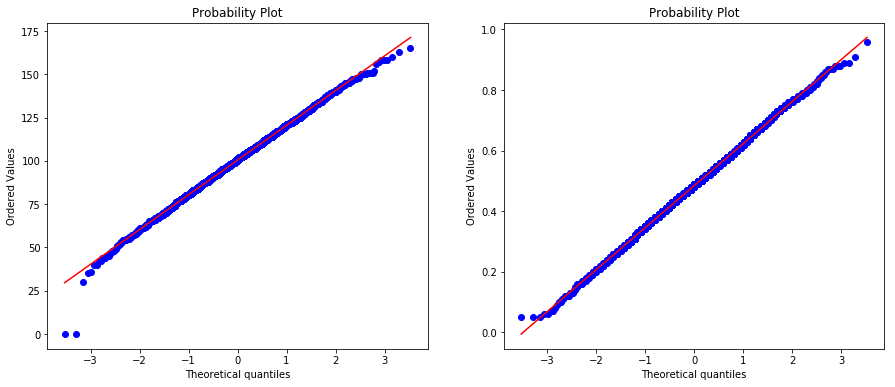

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sc.stats.probplot(churn['day_calls'], dist="norm", plot=plt);
plt.subplot(122)
sc.stats.probplot(churn['mes_estim'], dist="norm", plot=plt);

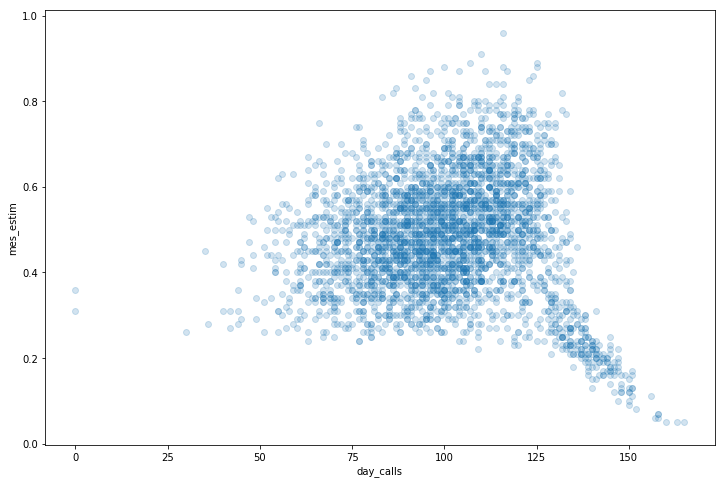

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(churn['day_calls'], churn['mes_estim'], alpha=0.2);
plt.xlabel('day_calls');
plt.ylabel('mes_estim');

### Вопрос 8

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [35]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [36]:
print('V Cramer stat value: %.4f' % cramers_stat(churn_states.values))

V Cramer stat value: 0.2004


In [37]:
print('p-value: %.4f' % stats.chi2_contingency(churn_states.values)[1])

p-value: 0.7098


### Вопрос 9

Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !

In [47]:
churn_states = pd.crosstab(churn['state'], [churn['treatment'], churn['churn']], rownames=['state'], colnames=['treatment', 'churn'])

In [48]:
churn_states

treatment     0           1           2      
churn     False True  False True  False True 
state                                        
AK           15     2    19     1    15     0
AL           22     1    25     5    25     2
AR           14     3    11     5    19     3
AZ           26     0    17     2    17     2
CA           10     3    10     5     5     1
CO           20     2    17     5    20     2
CT           22     3    25     5    15     4
DC           19     3    18     1    12     1
DE           18     4    16     1    18     4
FL           16     4    18     2    21     2
GA           11     5    19     2    16     1
HI           17     1    12     1    21     1
IA           13     1    13     2    15     0
ID           22     6    16     2    26     1
IL           25     2    11     1    17     2
IN           22     4    20     3    20     2
KS           21     2    18     7    18     4
KY           18     2    21     4    12     2
LA           11     1    15     0    21     3
MA           20     2    17     7    17     2
MD           11     6    19     5    23     6
ME           14     4    20     8    15     1
MI           22     6    17     5    18     5
MN           28     6    19     2    22     7
MO           22     1    17     4    17     2
MS           15     9    20     4    16     1
MT           19     6    22     4    13     4
NC           21     4    16     3    20     4
ND           17     2    21     3    18     1
NE           16     1    21     3    19     1
NH           20     3    10     2    17     4
NJ           12     7    20     4    18     7
NM           14     3    27     2    15     1
NV           11     3    18     6    23     5
NY           22     4    27     6    19     5
OH           25     3    22     2    21     5
OK           19     1    11     2    22     6
OR           18     7    18     3    31     1
PA           13     3    14     4    10     1
RI           15     1    18     4    26     1
SC           15     3    16     5    15     6
SD           19     2    20     3    13     3
TN           18     1    11     1    19     3
TX           26     7    14     6    14     5
UT           23     4    18     4    21     2
VA           22     2    20     3    30     0
VT           24     1    18     5    23     2
WA           20     4    16     7    16     3
WI           25     4    22     2    24     1
WV           37     2    27     5    32     3
WY           23     4    20     2    25     3

In [73]:
# Proportions of churn = 1 for each treatment
for i in churn['treatment'].unique():
    print('Treatment {0}, prop. of churn = 1: {1:.4f}'.format(i, (churn[(churn['treatment'] == i) & (churn['churn'] == True)].shape[0] / churn[churn['treatment'] == i].shape[0])))

Treatment 1, prop. of churn = 1: 0.1641
Treatment 0, prop. of churn = 1: 0.1456
Treatment 2, prop. of churn = 1: 0.1251


In [95]:
# Wilson intervals for proportions
for i in churn['treatment'].unique():
    print('Treatment {0}, prop. of churn = 1: {1}'.format(i, (proportion_confint(churn[(churn['treatment'] == i) & (churn['churn'] == True)].shape[0], churn[churn['treatment'] == i].shape[0], method = 'wilson'))))

Treatment 1, prop. of churn = 1: (0.14334706983717693, 0.18716506331819044)
Treatment 0, prop. of churn = 1: (0.1262891297794312, 0.16736787598019826)
Treatment 2, prop. of churn = 1: (0.1068800961786988, 0.14594875893019524)


Доверительный интервал для разности долей (независимые выборки)

In [99]:
churn['churn'] = np.where(churn['churn'] == True, 1, churn['churn'])
churn['churn'] = np.where(churn['churn'] == False, 0, churn['churn'])
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,0
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,0
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,0
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,0


In [100]:
churn['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [105]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

Z-критерий для разности долей (независимые выборки)

In [102]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [113]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [125]:
# print("Treatments 0 and 1: 95%% confidence interval for a difference between proportions: [%f, %f]" %\
#       proportions_diff_confint_ind(churn[churn['treatment'] == 0]['churn'], churn[churn['treatment'] == 1]['churn']))
# print("Treatments 0 and 2: 95%% confidence interval for a difference between proportions: [%f, %f]" %\
#       proportions_diff_confint_ind(churn[churn['treatment'] == 0]['churn'], churn[churn['treatment'] == 2]['churn']))
# print("Treatments 1 and 2: 95%% confidence interval for a difference between proportions: [%f, %f]" %\
#       proportions_diff_confint_ind(churn[churn['treatment'] == 1]['churn'], churn[churn['treatment'] == 2]['churn']))

In [139]:
for tr1, tr2 in combinations(range(3), 2):
    print("Treatments {0} and {1}: 95%% confidence interval for a difference between proportions: [{2:.6f} {2:.6f}]".format(tr1, tr2, *proportions_diff_confint_ind(churn[churn['treatment'] == tr1]['churn'], churn[churn['treatment'] == tr2]['churn'])))

Treatments 0 and 1: 95%% confidence interval for a difference between proportions: [-0.048489 -0.048489]
Treatments 0 and 2: 95%% confidence interval for a difference between proportions: [-0.007821 -0.007821]
Treatments 1 and 2: 95%% confidence interval for a difference between proportions: [0.009619 0.009619]


In [119]:
p_value_list = []

for tr1, tr2 in combinations(range(3), 2):
    p_value = proportions_diff_z_test(proportions_diff_z_stat_ind(churn[churn['treatment'] == tr1]['churn'], churn[churn['treatment'] == tr2]['churn']))
    print("Treatments {0} and {1}: p-value: {2:.6f}".format(tr1, tr2, p_value))
    
    p_value_list.append(p_value)
    
p_value_list

Treatments 0 and 1: p-value: 0.228331
Treatments 0 and 2: p-value: 0.156425
Treatments 1 and 2: p-value: 0.009348


[0.2283311639045107, 0.1564246886050802, 0.009348084294451109]

In [132]:
_, p_corrected, _, _ = multipletests(p_value_list, alpha = 0.05, method = 'fdr_bh') 
p_corrected

array([0.22833116, 0.22833116, 0.02804425])